<a href="https://colab.research.google.com/github/AlirezaSamari/DeepLearning-Pytorch-fastai-/blob/main/MNIST_Classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
!pip install livelossplot
from livelossplot import PlotLosses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.8 MB/s 


In [2]:
from fastcore import *
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [3]:
(path/'training').ls()

(#10) [Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/3')]

In [4]:
ones_ex = (path/'training'/'1').ls()

In [5]:
len(ones_ex)

6742

In [6]:
for i in (path/'training').ls():
  print(i)

/root/.fastai/data/mnist_png/training/7
/root/.fastai/data/mnist_png/training/8
/root/.fastai/data/mnist_png/training/0
/root/.fastai/data/mnist_png/training/5
/root/.fastai/data/mnist_png/training/2
/root/.fastai/data/mnist_png/training/6
/root/.fastai/data/mnist_png/training/9
/root/.fastai/data/mnist_png/training/1
/root/.fastai/data/mnist_png/training/4
/root/.fastai/data/mnist_png/training/3


In [7]:
image = Image.open((path/'training'/'1').ls()[10])
image

In [8]:
image.size

(28, 28)

In [9]:
image.mode
# 'L' is Gray-Scale

'L'

#Pytorch:
##Data preparation

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(), transforms.Normalize([0.5], [0.5])])

In [11]:
full_dataset = torchvision.datasets.ImageFolder((path/"training").as_posix(), transform = transform)

# Splitting the above dataset into a training and validation dataset
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

# Dataset using the "testing" folder
testing_set = torchvision.datasets.ImageFolder((path/"testing").as_posix(), transform = transform)

**Testing dataset:** Used to calculate our gradients and update our weights using the loss obtained forwarding the data through the network.

Validation dataset: Used to assess model performance on unseen data during the training. We tune our hyperparameters (learning rate, batch size, number of epochs, network structure etc.) to improve this performance.

In [12]:
# batch size = 64
bs = 64

In [13]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = bs, shuffle = True)
data_loaders = {"train": train_loader,
                "validation": validation_loader}

In [14]:
from torch.nn.modules.activation import LogSoftmax
seqmodel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.LogSoftmax(dim=1))

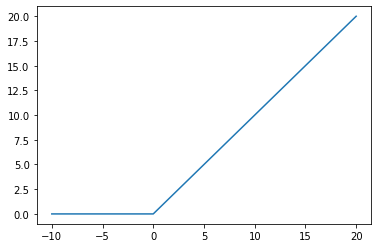

In [15]:
#ReLU
def relu_func(x):
  return torch.relu(x)

x = torch.linspace(-10, 20, 100)
y =relu_func(x)
import matplotlib.pyplot as plt
plt.plot(x, y)

In [16]:
# perform on GPU
device = torch.device('cuda:0')
print(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

cuda:0


In [17]:
#learning rate
lr = 1e-2
#number of epochs
n_epoch = 77

In [18]:
''' The optimizer object above will handle the stochastic gradient descent (SGD) step for us.
We need to pass it our model's parameters (so it can step on them) and a learning rate.

pytorch's nn.NLLLoss() for our loss function.
It stands for negative log likelihood loss and is useful to train a classification problem with more than 2 classes.
It expects log-probabilities as input for each class, which is our case after applying LogSoftmax.
'''

optimizer = torch.optim.SGD(seqmodel.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [19]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    liveloss = PlotLosses() # Live training plot generic API
    model = model.to(device) # Moves and/or casts the parameters and buffers to device.
    
    for epoch in range(num_epochs): # Number of passes through the entire training & validation datasets
        logs = {}
        for phase in ['train', 'validation']: # First train, then validate
            if phase == 'train':
                model.train() # Set the module in training mode
            else:
                model.eval() # Set the module in evaluation mode

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # count of carrectly classified inputs

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Perform Tensor device conversion
                labels = labels.to(device)

                outputs = model(inputs) # forward pass through network
                loss = criterion(outputs, labels) # Calculate loss

                if phase == 'train':
                    optimizer.zero_grad() # Set all previously calculated gradients to 0
                    loss.backward() # Calculate gradients
                    optimizer.step() # Step on the weights using those gradient w -=  gradient(w) * lr

                _, preds = torch.max(outputs, 1) # Get model's predictions
                running_loss += loss.detach() * inputs.size(0) # multiply mean loss by the number of elements
                running_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # get the "mean" loss for the epoch
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset) # Get proportion of correct predictions
            
            # Logging
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs) # Update logs
        liveloss.send() # draw, display stuff

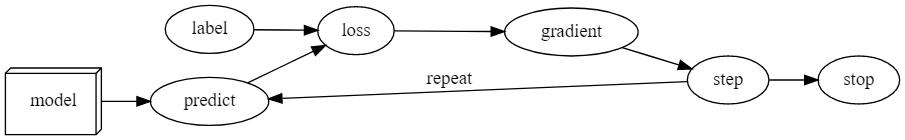

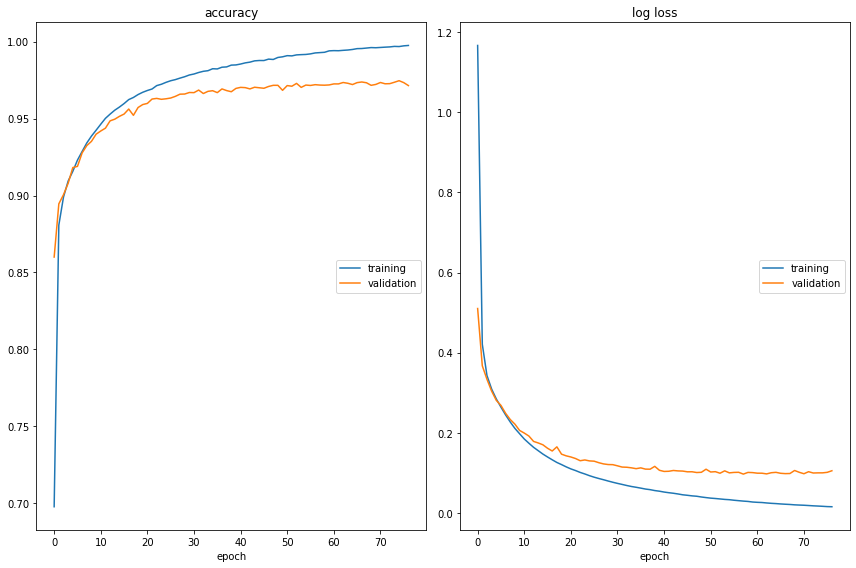

accuracy
	training         	 (min:    0.698, max:    0.997, cur:    0.997)
	validation       	 (min:    0.860, max:    0.975, cur:    0.971)
log loss
	training         	 (min:    0.016, max:    1.167, cur:    0.016)
	validation       	 (min:    0.097, max:    0.510, cur:    0.105)


In [20]:
train_model(seqmodel, criterion, optimizer, data_loaders, n_epoch)

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
torch.save(seqmodel, '/content/gdrive/My Drive/fastai/mnist_97_pytorch.pt')